# 用回归分析预测连续目标变量
## 线性回归简介
### 简单线性回归
### 多元线性回归

## 探索住房数据集
### 加载住房数据

In [1]:
import pandas as pd
df = pd.read_csv('./housing.data.txt',header=None,sep='\s+')
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE',
              'DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### 可视化数据集的重要特点

__探索性数据分析(EDA)__是在进行机器学习模型训练之前值得推荐的重要一步。本节的其余部分将使用图形化EDA工具箱中的一些简单而有用的技术，这些工具有助于直观地发现异常值的存在、数据的分布以及特征之间的关系。

先创建一个散点图矩阵，吧数据集中不同特征之间的成对相关性在一张图上直观地表示出来。调用Seaborn库地pairpolt函数绘制散点图矩阵，这是一个基与Matplotlib统计图地Python库。

可以通过Conda install seaborn或者pip install seaborn安装seaborn软件包。安装完成后，导入软件包并创建散点图矩阵。

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT','INDUS','NOX','RM','MEDV']
sns.pairplot(df[cols],height=2.5)
plt.tight_layout()
plt.show()

<Figure size 1250x1250 with 30 Axes>

### 用关联矩阵查看关系

关联矩阵是包含皮尔森积矩阵相关系数地正方形矩阵，用来度量特征对之间地线性依赖关系。相关系数在-1到1之间。如果r=1，则两个特征之间呈完美地正相关；如果r=0，泽良转之间没有关系；如果r=-1，则两者之间呈完全相反地关系。如前所述，皮尔森相关系数可以简单地计算为特征x和y之间地协方差除以标准偏差地乘积：

$$ r=\frac{\sum_{i=1}^{n}[(x^{(i)}-\mu_x)(y^{(i)}-\mu_y)]}{\sqrt{\sum_{i=1}^{n}(x^{(i)}-\mu_x)^2}\sqrt{\sum_{i=1}^{n}(y^{(i)}-\mu_y)^2}}=\frac{\sigma_{xy}}{\sigma_x\sigma_y} $$

这里，$\mu$为样本地均值，$\sigma_{xy}$为样本x和y之间地协方差，$\sigma_x$和$\sigma_y$为样本地标准偏差。

下面地代码示例将调用Numpy的corrcoef函数处理前面可视化散点图矩阵的五个特征列，调用Seaborn的heatmap函数基于关联矩阵阵列绘制热力图：

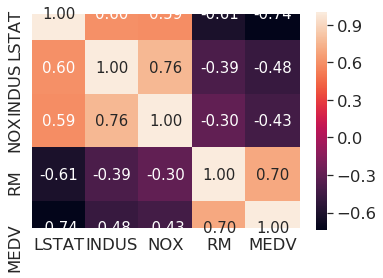

In [3]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

## 普通最小二乘线性回归OLS模型的实现

### 用梯度下降法求解回归参数

Adaline的成本函数市平方和误差（SSE），与OLS中用到的成本函数相同。

$$J(w)=\frac{1}{2}\sum_{i=1}^{n}(y^{(i)}-\hat{y}^{(i)})^2$$

这里$\hat{y}$为预测值$\hat{y}=w^Tx$（注意$\frac{1}{2}只是为了方便推导GD的更新规则）。OLS回归基本上可以理解为没有单位阶跃函数的Adaline，转阳就可以得到连续的目标值，而不是分类标签-1和1。为了证明这一点，第二章中的Adaline GD实施为基础，去除单位阶跃函数来实现第一个线性回归模型。

In [4]:
class LinearRegressionGD(object):
    def __init__(self,eta=0.001,n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self,X,y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self,X):
        return np.dot(X,self.w_[1:]) + self.w_[0]
    
    def predict(self,X):
        return self.net_input(X)

为了观察LinearRegressionGD回归其的具体行为，我们用住房数据的RM（房间数）变量作为解释变量，训练可以预测MEDV（房价）的模型。此外标准化变量以确保GD算法具有更好的收敛性，代码如下：

In [5]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:,np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std,y_std)    

你可能已经注意到使用np.newaxisx和flatter变通y_std的方法。scikit-learn的大多数转换器期望数据存储在二维阵列。前面的代码示例用y\[:,np.newaxis\]为阵列添加了一个新维度。然后，StandardScaler返回比例尺度调整后的变量，为了方便用flatten()方法将其转换回原来的一维阵列。

/home/linux1/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/linux1/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/linux1/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/linux1/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/linux1/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 

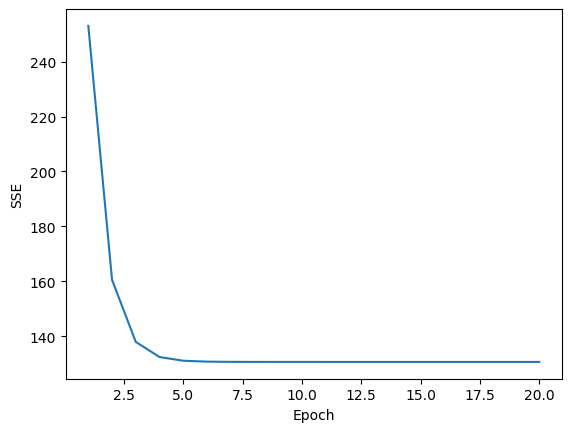

In [6]:
sns.reset_orig() # resets matplotlib style
plt.plot(range(1,lr.n_iter+1),lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [7]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='steelblue',edgecolor='white',s=70)
    plt.plot(X,model.predict(X),color='black',lw=2)
    return None

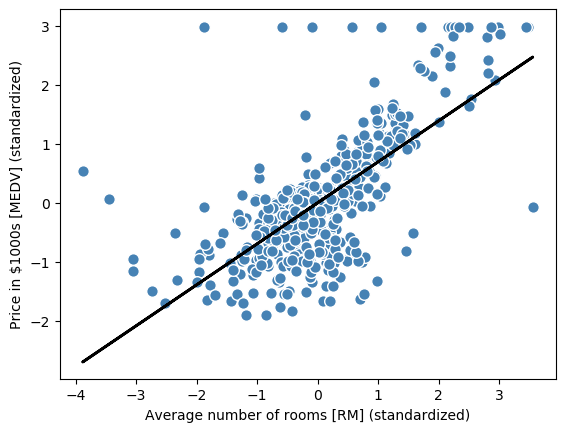

In [8]:
lin_regplot(X_std,y_std,lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

虽然改观察结果很自然，但数据也告诉我们，在许多情况下，房间数并不能很好地解释房价。本章后面将讨论如何量化评估回归模型地性能。有趣的市观察到在$y=3$的时候有几个数据点变成了一个横排，这表明价格对房间数可能已经不再敏感。在某些应用中，将预测结果变量以原来的比例尺都进行报告也很重要。可以直接调用StandarsScaler的inverse_transform方法把价格的预测结果恢复到以1000美元为单位的坐标轴：

In [9]:
num_rooms_std = sc_x.transform(np.array([5.0]).reshape(-1,1))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % \
      sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


另一方面，如果是处理标准化变量，从技术角度来说，不需要更新截距的权重，因为在这些情况下，y轴的截距总是0。

In [10]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


### 通过scikit-learn估计回归模型的系数

上一节实现了一个可用的回归分析模型。然而，在实际应用中，可能对所实现模型的高效性更感兴趣。例如，许多scikit-learn回归估计其使用LIBLINEAR库，它有先进的优化算法，以及对非标准变量更有效的代码优化手段，这对某些应用来说很有用：

In [11]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


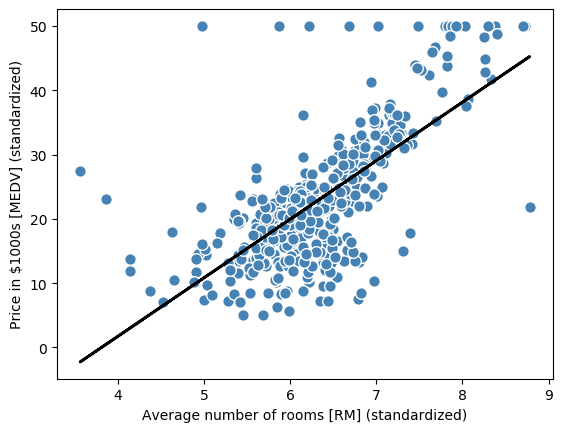

In [12]:
lin_regplot(X,y,slr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

除机器学习库外，另一个选择市用封闭形态的OLS解决方案，这涉及到线性方程组，可以从大多数入门级统计教科书中找到相应的介绍：

$$w=(X^TX)^{-1}X^Ty$$

In [13]:
Xb = np.hstack((np.ones((X.shape[0],1)),X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T,Xb))
w = np.dot(z,np.dot(Xb.T,y))
print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


这种方法的有点市保证正通过分析找到最优解。然而，如果面对非常大的数据集，那么计算可能过于昂贵，以至于无法完成（有时也称为正规方程）逆矩阵，或者样本矩阵可能市奇异的（非可逆的），这就是为什么在某些情况下我们可能更喜欢迭代法。

## 利用RANSAC拟合稳健的回归模型

线性回归模型可能会受到离群值的严重影响。在某些情况下，一小部分数据可能会对估计的模型系数有很大的影响。有许多统计测试可以用来检测异常值，这超出了本书的范围。然而，去除异常值需要数据科学家以及领域知识的判断。

除了淘汰离群值之外，还有一种更为稳健的回归方法，即采用__随机抽样一致性(RANSAC)__的算法，根据数据子集（所谓的内点）拟合回归的模型。

总结迭代RANSAC算法如下：
1. 随即选择一定数量的样本作为内点来拟合模型。
2. 用模型测试所有其他的点，把落在用户给定容限范围内的点放入内点集。
3. 调整模型中使用的所有的内点。
4. 用内点重新拟合模型。
5. 评估模型预测结果与内点集相比较的误差。
6. 如果性能达到用户定义的阈值或指定的迭代数，则终止；否则返回步骤一。

In [14]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False),
                is_data_valid=None, is_model_valid=None, loss='absolute_loss',
                max_skips=inf, max_trials=100, min_samples=50, random_state=0,
                residual_threshold=5.0, stop_n_inliers=inf,
                stop_probability=0.99, stop_score=inf)

设置__RANSACRegressor__的最大迭代数为100，设置随机选择样本的最低数量至少为50，__min\_samples = 50__。用‘__absolute\_loss__’作为形式参数__residual\_metric__的实际参数，该算法计算拟合线和采样点之间的绝对垂直距离。通过设置__residual\_threshold__参数为0.5，我们只允许与拟合线垂直距离在5个单位以内的采样点被包括在内点集，这对该特定数据集的效果很好。

在默认情况下，scikit-learn用__MAD__评估内点选择的阈值，__MAD__使目标值__y__的__平均绝对偏差(Median Absolute Deviation)__的缩写。然而，选择适当的内点阈值因问题而宜，这是RANSAC的不利点。

在拟合RANSAC模型之后，可以根据RANSAC算法拟合的线性回归模型获得内点和离群点，并且把这些点和线性拟合的情况绘制成图：

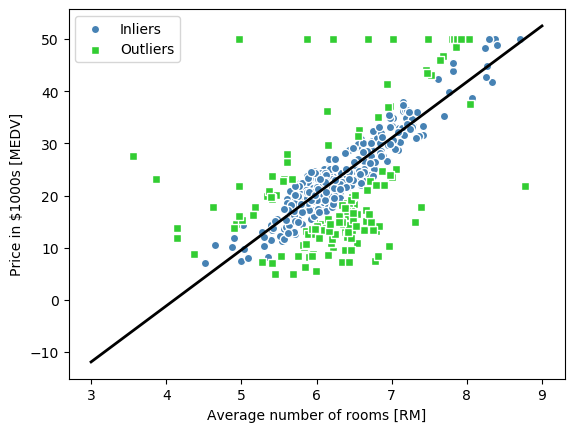

In [15]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],
            c='steelblue',edgecolor='white',
            marker='o',label='Inliers')
plt.scatter(X[outlier_mask],y[outlier_mask],
            c='limegreen',edgecolor='white',
            marker='s',label='Outliers')
plt.plot(line_X,line_y_ransac,color='black',lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [16]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## 评估线性回归模型的性能

不再使用简单的回归模型，而是用数据集中的所有变量来训练多元回归模型：

In [17]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test = train_test_split(
        X,y,test_size=0.3,random_state=0)
slr = LinearRegression()
slr.fit(X_train,y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

由于模型使用了多个解释变量，所以无法在二维图中可视化线性回归线（更准确地说是超平面），但可以通过绘制残差（实际值和预测值之间地差异或垂直距离）与预测值来判断回归模型。__残差图__是判断回归模型常用地图形工具。这有助于检测非线性和异常值，并检查这些错误是否随机分布。

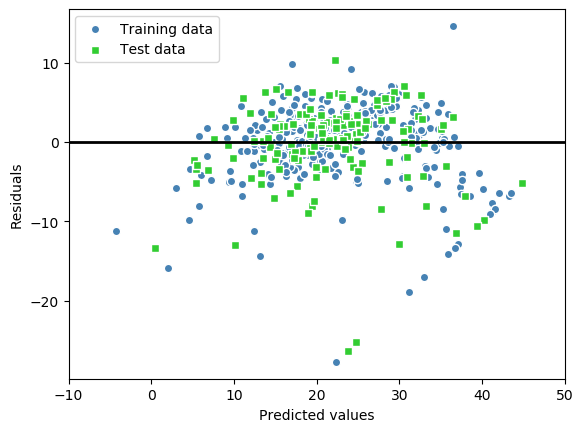

In [18]:
plt.scatter(y_train_pred,y_train_pred-y_train,
            c='steelblue',marker='o',edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,y_test_pred-y_test,
            c='limegreen',marker='s',edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-10,xmax=50,color='black',lw=2)
plt.xlim([-10,50])
plt.show()

在完美预测的情况下，，残差刚好为零，这是在现实和实际应用中可能永远都不好遇到的。然而，我们期望好的回归模型的误差呈随机分布，残差应该随机分布在中心线附近。如果从残差图中看到模式存在，这意味着模型无法捕捉到一些解释性信息，这些信息已经泄露到了残差中，像在前面的残差图中所看到那样。此外，还可以用残差图来检测离群点，这些离群点有图中与中心线存在很大偏差的那些点来表示。

另一个有用的模型性能定量度量是所谓的__均方误差(MSE)__，它仅仅是为了拟合线性回归模型，而将SSE成本均值最小化的结果。MSE'对比较不同的回归模型或通过网格搜索和交叉验证调整其参数很有用，因为它通过调整样本比例尺寸是SSE归一化。

$$MSE=\frac{1}{n}\sum_{i=1}^{n}(y^{(i)}-\hat{y}^{(i)})^2$$

In [19]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
       mean_squared_error(y_train,y_train_pred),
       mean_squared_error(y_test,y_test_pred)))

MSE train: 19.958, test: 27.196


有时候__报告决定系数($R^2$)__可能更有用，可以把着理解为MSE的标准版，目的是为更好地解释模型地性能。换句话说，$R^2$是模型捕获到的响应方差函数地一部分。定义$R^2$值如下：

$$R^2=1-\frac{SSE}{SST}$$

这里的SSE是平方误差之和，而SST是平方和之总和：

$$SST=\sum_{i=1}^{n}(y^{(i)}-\mu_y)^2$$

换句话说，SST知识反应地方差。

In [20]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % 
      (r2_score(y_train,y_train_pred),
       r2_score(y_test,y_test_pred)))

R^2 train: 0.765, test: 0.673


## 用正则化方法进行回归

正则化是通过添加额外信息解决过拟合问题地一种方法，而缩小模型参数值却引来了复杂性地惩罚。正则化线性回归最常用地方法包括所谓地__岭回归__、__最小绝对收缩与选择算子(LASSO)__以及__弹性网络__。

岭回归是一个L2惩罚模型，只需把加权平方添加到最小二乘代价函数：

$$J(w)_{Ridge}=\sum_{i=1}^{n}(y^{(i)}-\hat{y}^{(i)})^2+\lambda\Vert{w}\Vert_2^2$$

这里：

$$L2:\lambda\Vert{w}\Vert^2_2=\lambda\sum_{j=1}^{m}w_j^2$$

通过加大超参数$\lambda$地值，我们增加了正则化地强度，同时收缩了模型地权重。注意，不要正则化截距项$w_0$

另一种可能导致稀疏模型地方法是LASSO。取决于正则化地强度，某些权重可能称为零，这也使LASSO成为有监督特征选择的有用技术：

$$J(w)_{LASSO}=\sum_{i=1}^{n}(y^{(i)}-\hat{y}^{(i)})^2+\lambda\Vert{w}\Vert_1$$

这里：

$$L1:\lambda\Vert{w}\Vert_1=\lambda\sum_{i=1}^{m}|w_j|$$

然而，如果$m>n$，LASSO的限制是最多可以选择n个变量。处于岭回归和LASSO之间的这种方案是弹性网络，它以一个L1惩罚来产生稀疏性，以一个L2惩罚来克服LASSO的一些限制，例如选择变量的数量：

$$J(W)_{ElasticNet}=\sum_{i=1}^{n}(y^{(i)}-\hat{y}^{(i)})^2+\lambda_1\sum_{j=1}^{m}w^2_j++\lambda_2\sum_{j=1}^{m}|w_j|$$

## 将线性回归模型转换为曲线——多项式回归

一种有效解决违背线性假设的方法是通过增加项数采用多项式回归模型：

$$y=w_0+w_1x+w_2x^2+\cdots+w_dx^d$$

这里$d$为多项式的次数。虽然可以用多项式回归来模拟非线性关系，当时因为存在线性回归系数$w$，他仍然被认为是多元线性回归模型。

### 用scikit-learn增加多项式的项

1. 增加二次多项式
2. 为了比较，拟合一个简单的线性回归模型
3. 用变换后的特征以多项式回归拟合多元回归模型
4. 绘制出结果

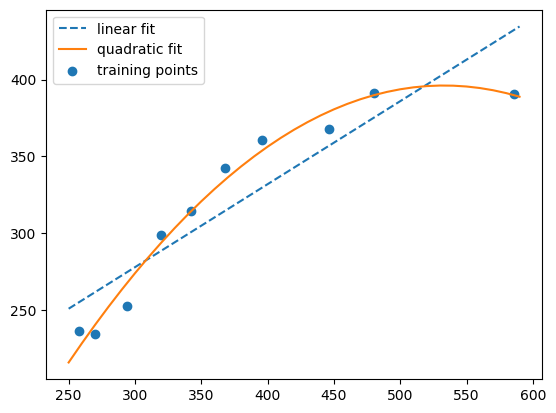

In [22]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0,270.0,294.0,320.0,342.0,
              368.0,396.0,446.0,480.0,586.0])\
              [:,np.newaxis]
y = np.array([236.4,234.4,252.8,298.6,314.2,
              342.2,360.8,368.0,391.2,390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

lr.fit(X,y)
X_fit = np.arange(250,600,10)[:,np.newaxis]
y_lin_fit = lr.predict(X_fit)

pr.fit(X_quad,y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X,y,label='training points')
plt.plot(X_fit,y_lin_fit,
         label='linear fit',linestyle='--')
plt.plot(X_fit,y_quad_fit,
         label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [23]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y,y_lin_pred),
        mean_squared_error(y,y_quad_pred)))

print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y,y_lin_pred),
        r2_score(y,y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


### 为住房数据集中的非线性关系建模

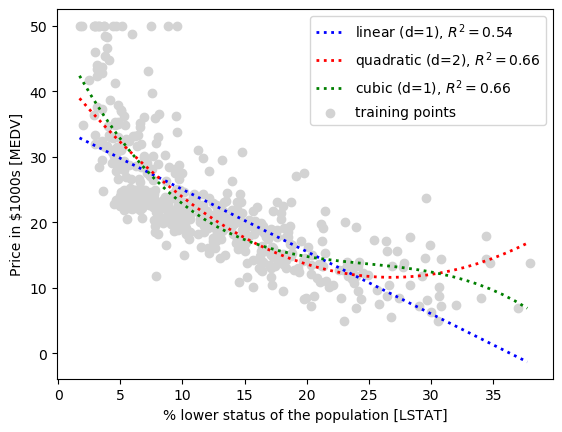

In [28]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

#Create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

#fit feature
X_fit = np.arange(X.min(),X.max(),1)[:,np.newaxis]

regr = regr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y,regr.predict(X))

regr = regr.fit(X_quad,y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y,regr.predict(X_quad))

regr = regr.fit(X_cubic,y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y,regr.predict(X_cubic))

#plot results
plt.scatter(X,y,label='training points',color='lightgray')

plt.plot(X_fit,y_lin_fit,
         label='linear (d=1), $R^2=%.2f$' % linear_r2,
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit,y_quad_fit,
         label='quadratic (d=2), $R^2=%.2f$' % cubic_r2,
         color='red',
         lw=2,
         linestyle=':')

plt.plot(X_fit,y_cubic_fit,
         label='cubic (d=1), $R^2=%.2f$' % cubic_r2,
         color='green',
         lw=2,
         linestyle=':')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

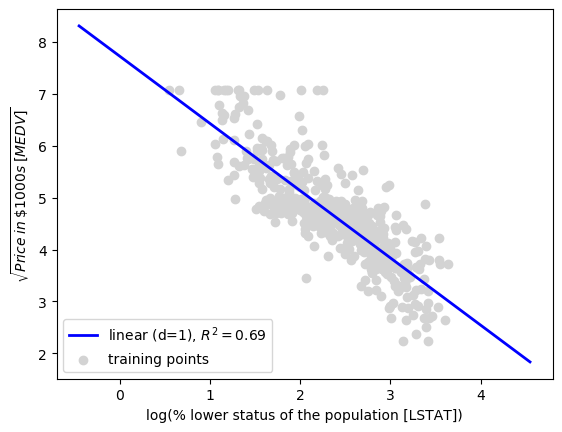

In [29]:
# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1,
                  X_log.max()+1,1)[:,np.newaxis]
regr = regr.fit(X_log,y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt,regr.predict(X_log))

# plot results
plt.scatter(X_log,y_sqrt,
            label='training points',
            color='lightgray')
plt.plot(X_fit,y_lin_fit,
         label='linear (d=1), $R^2=%.2f$' % linear_r2,
         color='blue',
         lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

## 用随即森林处理非线性关系

本节将讨论随机森林回归，它与本章之前的回归模型再概念上有所不同。松坂城森林是多个决策树的集合，可以理解为分段线性函数之和，与以前讨论过的全局性线性和多项式回归模型相反。换句话说，通过决策树算法，可以进一步将输入空间细分为更小的区域，这些区域也将变得更易于管理。

### 决策树回归

决策树算法的一个优点是，如果处理非线性数据，它不需要对特征进行任何转换。当用决策树进行分类时，定义熵作为杂质的指标以确定那个特征分割可以最大化__信息增益(IG)__，二元分割可以定义为：

$$IG(D_p,x_i)=I(D_p)-\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$$

这里$x$是要分裂的样本特征，$N_p$为父节点的样本数，$I$为杂质函数，$D_p$是父节点训练样本子集。$D_{left}$和$D_{right}$为分裂后左右子节点的训练样本集。记住，目标是要找到可以最大化信息增益的特征分裂；换句话说，希望找到可以减少子节点中杂质的特征分裂。为了把好高决策树用于回归，需要一个适合连续变量的在职指标，所以，作为替换，我们把节点$t$的杂质指标定义为MSE:

$$I(t)=MSE(t)=\frac{1}{N_t}\sum_{i\in D_i}(y^{(i)}-\hat{y}_t)^2$$

这里$N_t$为节点$t$的训练样本数，$D_t$为节点$t$的训练子集，$y^{(i)}$为真实的目标值，$\hat{y}_t$为预测的目标值（样本均值）：

$$\hat{y}_t=\frac{1}{N_t}\sum_{i\in D_i}y^{(i)}$$

再决策数回归的背景下，MSE通常也被称为__节点方差__，这就是为什么分裂标准也被称为__方差缩减__。用scikit-learn实现的DecisionTreeRegressir为变量MEDV和LSTAT之间的非线性关系建模：

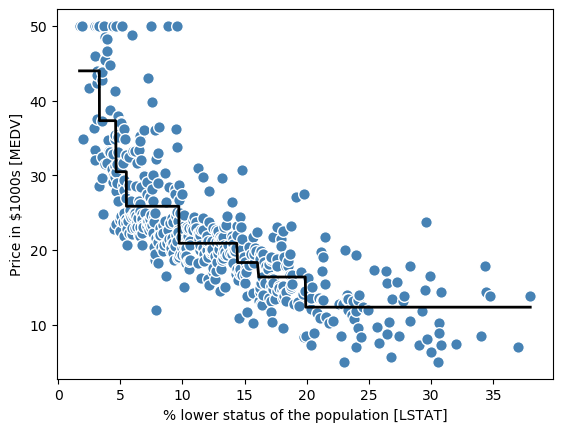

In [30]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx],y[sort_idx],tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

### 随机森林回归

随即森林算法是一种组合了多个决策树的技术。由于随机性，随即森林通常比单个决策树具有更好的泛化性能，这有助于减少模型的方差。随机森林的其他优点还包括它对数据集中的离群值不敏感，而且也不需要太多的参数优化。随机森林中通常唯一需要试验的参数是组合中决策树的个数。基本的回归随机森林算法与随机分类算法几乎相同，唯一不同的是用MSE准则来培育每棵决策树，并用决策树平均预测值来计算预测的目标变量。

In [32]:
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test =\
    train_test_split(X,y,
                     test_size=0.4,
                     random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
       mean_squared_error(y_train,y_train_pred),
       mean_squared_error(y_test,y_test_pred)))
print('R^2 train: %.3f, test: %.3f' %(
       r2_score(y_train,y_train_pred),
       r2_score(y_test,y_test_pred)))

MSE train: 1.641, test: 11.056
R^2 train: 0.979, test: 0.878


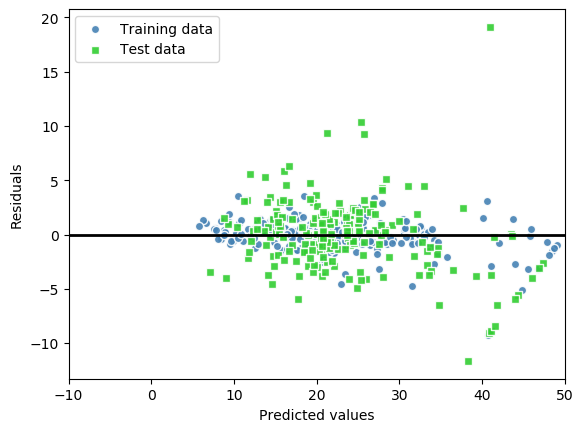

In [34]:
plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=35,
            alpha=0.9,
            label='Training data')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='limegreen',
            edgecolor='white',
            marker='s',
            s=35,
            alpha=0.9,
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color='black')
plt.xlim([-10,50])
plt.show()

## 小结